## Mortality Model Using MIMIC ICU Data*

This is an open case study problem for you.  Your goal is to develop a model to predict mortality in the ICU given by the `hospital_expire_flag`.  We will judge the model using two criteria:

- the `roc_auc_score` of your predictions -- this measures how well your model ranked the cases from riskiest to least risky
- the `log_loss` of your predictions -- this measures how accurate your probabilities of mortality were.


Please roughly go through the following steps:

1) Build a test/train split using the `random_state=42` given in the code below. 

2) Explore the data.  Write at least one reusable function that you find useful in exploring the data.  There is missing data in many columns, so you will have to decide how to deal with that.

3) Build a simple "baseline" model.  See how well you can do with just 3-5 variables in predicting mortality.  In fact, have one baseline model with Logistic Regression and another with a Random Forest.

4) Build a more complicated model.  Use more variables and more complicated methods and see how much you can improve from your baseline.  Use at least one Penalized Logistic Regression model and one Random Forest or Gradient Boosted model.

5) "Engineer" at least one feature and demonstrate how it improved your model.


*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016).
https://mimic.physionet.org


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

pd.set_option("display.max_columns",200)

In [2]:
# Load dataset derived from the MMIC database

lab_aug_df = pd.read_csv("data/lab_vital_icu_table.csv")

In [3]:
lab_aug_df.head(10)

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,bilirubin_max,creatinine_min,creatinine_max,chloride_min,chloride_max,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,lactate_min,lactate_max,platelet_min,platelet_max,potassium_min,potassium_max,ptt_min,ptt_max,inr_min,inr_max,pt_min,pt_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,subject_id.1,hadm_id.1,icustay_id.1,gender,admittime,dischtime,los_hospital,age,ethnicity,admission_type,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,first_icu_stay,subject_id.2,hadm_id.2,icustay_id.2,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,meanbp_max,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,NaN,NaN,26.0,30.0,0.4,0.4,1.2,1.4,100.0,103.0,37.4,45.2,12.9,15.4,1.9,2.7,249.0,258.0,2.8,3.0,21.7,21.7,1.1,1.1,12.7,12.7,136.0,140.0,16.0,17.0,7.5,13.7,9,150750,220597,M,2149-11-09 13:06:00,2149-11-14 10:15:00,5.0,41.7887,UNKNOWN/NOT SPECIFIED,EMERGENCY,1,1,Y,2149-11-09 13:07:02,2149-11-14 20:52:14,5.0,1,Y,9,150750,220597,82.0,111.0,92.500000,106.0,217.0,159.375000,53.0,107.0,79.525000,67.000000,132.000,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,0.4,0.5,0.8,106.0,116.0,24.0,35.6,7.9,12.3,NaN,NaN,115.0,216.0,3.0,5.3,30.8,44.1,1.2,1.8,13.3,16.5,137.0,140.0,13.0,18.0,16.6,19.3,13,143045,263738,F,2167-01-08 18:43:00,2167-01-15 15:15:00,7.0,39.8640,WHITE,EMERGENCY,0,1,Y,2167-01-08 18:44:25,2167-01-12 10:43:31,4.0,1,Y,13,143045,263738,60.0,124.0,83.600000,102.0,151.0,126.136364,53.0,84.0,66.000000,73.000000,111.000,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,NaN,NaN,21.0,21.0,NaN,NaN,0.8,0.8,108.0,108.0,26.0,35.0,8.5,11.8,NaN,NaN,111.0,132.0,3.6,4.6,31.3,34.2,1.3,1.6,14.1,15.7,137.0,143.0,18.0,18.0,17.5,17.5,20,157681,264490,F,2183-04-28 09:45:00,2183-05-03 14:45:00,5.0,75.8757,WHITE,ELECTIVE,0,1,Y,2183-04-28 15:00:36,2183-04-29 16:13:48,1.0,1,Y,20,157681,264490,67.0,80.0,79.121951,81.0,167.0,127.825000,36.0,76.0,54.500000,52.000000,102.000,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,NaN,NaN,23.0,23.0,NaN,NaN,0.9,1.0,109.0,112.0,26.0,41.0,8.6,13.6,NaN,NaN,137.0,150.0,3.8,5.2,31.8,32.0,1.1,1.4,13.0,15.1,136.0,141.0,13.0,17.0,6.9,6.9,28,162569,225559,M,2177-09-01 07:15:00,2177-09-06 16:00:00,5.0,74.3836,WHITE,ELECTIVE,0,1,Y,2177-09-01 09:32:26,2177-09-02 12:28:42,1.0,1,Y,28,162569,225559,74.0,103.0,88.428571,98.0,153.0,121.266667,38.0,61.0,47.933333,55.000000,86.000,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,NaN,NaN,33.0,35.0,NaN,NaN,0.8,1.0,100.0,103.0,28.9,33.9,9.5,10.3,NaN,NaN,263.0,310.0,3.8,4.0,24.1,24.6,1.1,1.2,13.1,13.3,139.0,143.0,25.0,37.0,10.4,13.9,37,188670,213503,M,2183-08-21 16:48:00,2183-08-26 18:54:00,5.0,68.9269,WHITE,EMERGENCY,0,1,Y,2183-08-23 12:01:45,2183-08-24 15:22:53,1.0,1,Y,37,188670,213503,69.0,91.0,81.000000,103.0,144.0,123.035714,33.0,60.0,48.428571,65.333298,82.000,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333
5,71,111944,211832,13.0,30.0,3.6,4.7,17.0,26.0,0.4,0.5,0.5,0.8,101.0,113.0,31.1,37.3,11.3,13.1,2.9,8.3,215.0,295.0,3.2,3.9,26.1,26.1,1.1,1.1,13.1,13.1,141.0,145.0,4.0,16.0,15.0,27.0,71,111944,211832,F,2164-02-03 22:07:00,2164-02-08 14:00:00,5.0,36.5046,ASIAN,EMERGENCY,0,1,Y,2164-02-03 22:07:49,2164-02-06 18:47:31,3.0,1,Y,71,111944,211832,98.0,137.0,112.444444,94.0,157.0,114.629630,31.0,130.0,61.518519,58.000000,139.000,79.222208,13.0,25.0,17.130435,35.722224,37.833332,37.351852,99.0,100.0,99.862069
6,72,156857,239612,18.0,18.0,NaN,NaN,20.0,20.0,3.5,3.5,0.6,0.6,

## Test/train split done here

In [4]:
X_full = lab_aug_df.drop(['hospital_expire_flag'], axis=1)
y = lab_aug_df.hospital_expire_flag

X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=.3, random_state=42)

In [5]:
## Verify the split was the same for you and your neighbor
np.mean(X_train_full.age), np.mean(X_test_full.age)

(65.77252070895523, 65.16924826431521)

## Do some Exploratory Data Analysis here

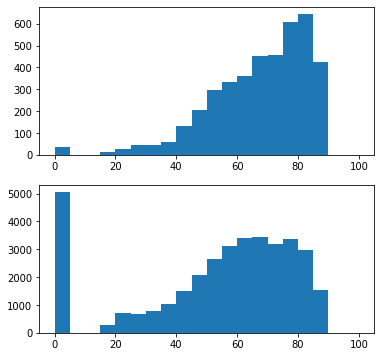

In [6]:
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.hist(X_train_full.loc[y_train==1,'age'], bins=np.linspace(0,100,21));
plt.subplot(2,1,2)
plt.hist(X_train_full.loc[y_train==0,'age'], bins=np.linspace(0,100,21));

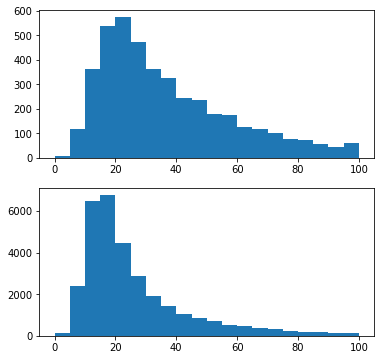

In [7]:
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.hist(X_train_full.loc[y_train==1,'bun_max'], bins=np.linspace(0,100,21));
plt.subplot(2,1,2)
plt.hist(X_train_full.loc[y_train==0,'bun_max'], bins=np.linspace(0,100,21));

In [8]:
def pair_of_histograms(binary_vector, numeric_vector, bins=None):
    if bins is None:
        bins = np.linspace(np.min(numeric_vector),np.max(numeric_vector), 21)
    plt.figure(figsize=(6,6))
    plt.subplot(2,1,1)
    plt.hist(numeric_vector[binary_vector==1], bins=bins);
    plt.title('Positive Case Distribution')
    plt.subplot(2,1,2)
    plt.hist(numeric_vector[binary_vector==0], bins=bins);
    plt.title('Negative Case Distribution')


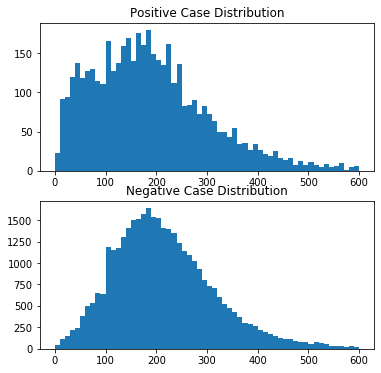

In [9]:
pair_of_histograms(y_train, X_train_full.platelet_min, bins = np.linspace(0,600,61))

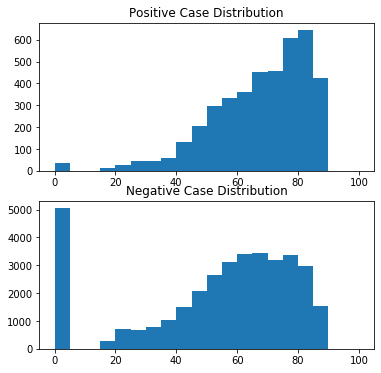

In [10]:
pair_of_histograms(y_train, X_train_full.age, bins = np.linspace(0,100,21))

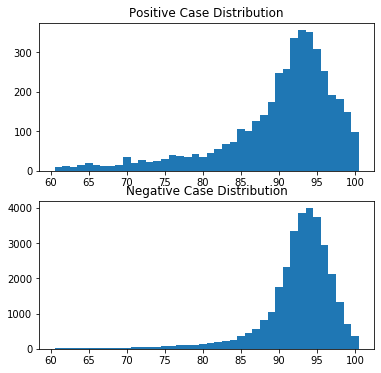

In [11]:
pair_of_histograms(y_train, X_train_full.spo2_min, bins = np.linspace(60,100,41)+.5)

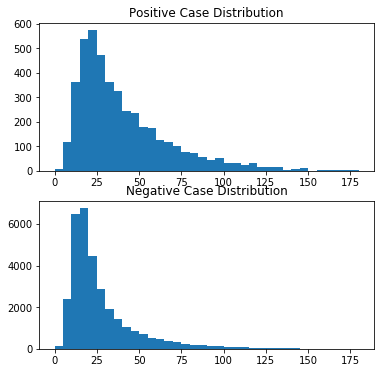

In [12]:
pair_of_histograms(y_train, X_train_full.bun_max, bins = np.linspace(0,180,37))

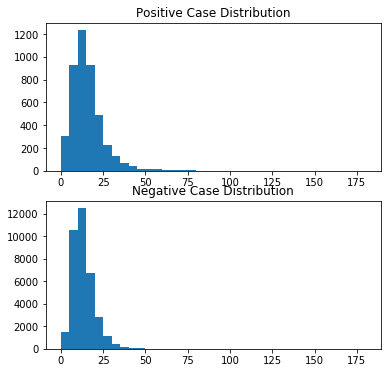

In [13]:
pair_of_histograms(y_train, X_train_full.wbc_max, bins = np.linspace(0,180,37))

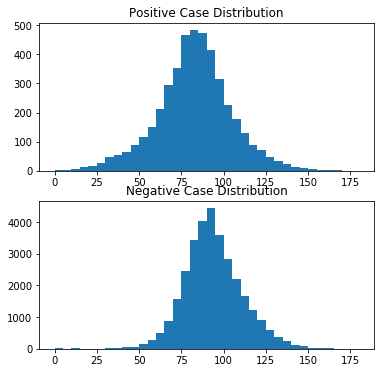

In [14]:
pair_of_histograms(y_train, X_train_full.sysbp_min, bins = np.linspace(0,180,37))

### Make a function that helps your EDA here

In [15]:
def pair_of_histograms(binary_vector, numeric_vector, bins=None):
    if bins is None:
        bins = np.linspace(np.min(numeric_vector),np.max(numeric_vector), 21)
    plt.figure(figsize=(6,6))
    plt.subplot(2,1,1)
    plt.hist(numeric_vector[binary_vector==1], bins=bins);
    plt.title('Positive Case Distribution')
    plt.subplot(2,1,2)
    plt.hist(numeric_vector[binary_vector==0], bins=bins);
    plt.title('Negative Case Distribution')


## Build your baseline model here

In [16]:
baseline_feats = ['age','spo2_min','bun_max','sysbp_min']
X_train_bl = X_train_full.loc[:,baseline_feats].copy()
X_test_bl = X_test_full.loc[:,baseline_feats].copy()

In [17]:
X_train_bl['spo2_min'] = X_train_bl.spo2_min.fillna(X_train_bl['spo2_min'].median())
X_train_bl['bun_max'] = X_train_bl.bun_max.fillna(X_train_bl['bun_max'].median())
X_train_bl['sysbp_min'] = X_train_bl.sysbp_min.fillna(X_train_bl['sysbp_min'].median())

X_test_bl['spo2_min'] = X_test_bl.spo2_min.fillna(X_train_bl['spo2_min'].median())
X_test_bl['bun_max'] = X_test_bl.bun_max.fillna(X_train_bl['bun_max'].median())
X_test_bl['sysbp_min'] = X_test_bl.sysbp_min.fillna(X_train_bl['sysbp_min'].median())

In [18]:
lr_baseline = LogisticRegression(solver='lbfgs')
lr_baseline.fit(X_train_bl, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
pred_probs_lr_bl = lr_baseline.predict_proba(X_test_bl)[:,1]

In [20]:
roc_auc_score(y_test, pred_probs_lr_bl), log_loss(y_test, pred_probs_lr_bl)

(0.7490566267406759, 0.2994541538018322)

In [21]:
rf_bl = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf_bl.fit(X_train_bl, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [22]:
pred_probs_rf_bl = rf_bl.predict_proba(X_test_bl)[:,1]
roc_auc_score(y_test, pred_probs_rf_bl), log_loss(y_test, pred_probs_rf_bl)

(0.7608989801328393, 0.3170760452962717)

In [23]:
gb_bl = GradientBoostingClassifier(max_depth=4)
gb_bl.fit(X_train_bl, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [24]:
pred_probs_gb_bl = gb_bl.predict_proba(X_test_bl)[:,1]
roc_auc_score(y_test, pred_probs_gb_bl), log_loss(y_test, pred_probs_gb_bl)

(0.7928422202024793, 0.2817471526933136)

## Build your more complicated models here

In [25]:
huge_feat_list = ['aniongap_min', 'aniongap_max',
       'albumin_min', 'albumin_max', 'bicarbonate_min', 'bicarbonate_max',
       'bilirubin_min', 'bilirubin_max', 'creatinine_min', 'creatinine_max',
       'chloride_min', 'chloride_max', 'hematocrit_min', 'hematocrit_max',
       'hemoglobin_min', 'hemoglobin_max', 'lactate_min', 'lactate_max',
       'platelet_min', 'platelet_max', 'potassium_min', 'potassium_max',
       'ptt_min', 'ptt_max', 'inr_min', 'inr_max', 'pt_min', 'pt_max',
       'sodium_min', 'sodium_max', 'bun_min', 'bun_max', 'wbc_min', 'wbc_max',
       'heartrate_min', 'heartrate_max', 'heartrate_mean',
       'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max',
       'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean',
       'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min',
       'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean']

In [26]:
X_train_huge = X_train_full.loc[:,huge_feat_list].copy()
X_test_huge = X_test_full.loc[:,huge_feat_list].copy()

In [27]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='median')

/Users/brianlucena/.pyenv/versions/mypy373/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [28]:
imp.fit(X_train_huge)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [29]:
X_train_huge = imp.transform(X_train_huge)
X_test_huge = imp.transform(X_test_huge)


In [30]:
gb_huge = GradientBoostingClassifier(max_depth=3)
gb_huge.fit(X_train_huge, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [31]:
pred_probs_gb_huge = gb_huge.predict_proba(X_test_huge)[:,1]
roc_auc_score(y_test, pred_probs_gb_huge), log_loss(y_test, pred_probs_gb_huge)

(0.8630928068038546, 0.24231710927011874)

In [32]:
gb_huge4 = GradientBoostingClassifier(max_depth=4)
gb_huge4.fit(X_train_huge, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
pred_probs_gb_huge4 = gb_huge4.predict_proba(X_test_huge)[:,1]
roc_auc_score(y_test, pred_probs_gb_huge4), log_loss(y_test, pred_probs_gb_huge4)

(0.8668746886014876, 0.23955372908632064)

In [34]:
gb_huge5 = GradientBoostingClassifier(max_depth=5)
gb_huge5.fit(X_train_huge, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
pred_probs_gb_huge5 = gb_huge5.predict_proba(X_test_huge)[:,1]
roc_auc_score(y_test, pred_probs_gb_huge5), log_loss(y_test, pred_probs_gb_huge5)

(0.8674013288569233, 0.23933046008723718)

In [36]:
gb_huge4a = GradientBoostingClassifier(max_depth=4, subsample=.9)
gb_huge4a.fit(X_train_huge, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [37]:
pred_probs_gb_huge4a = gb_huge4a.predict_proba(X_test_huge)[:,1]
roc_auc_score(y_test, pred_probs_gb_huge4a), log_loss(y_test, pred_probs_gb_huge4a)

(0.8656523125799589, 0.239467917128924)

In [38]:
gb_huge5a = GradientBoostingClassifier(max_depth=5, n_estimators=200)
gb_huge5a.fit(X_train_huge, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [39]:
pred_probs_gb_huge5a = gb_huge5a.predict_proba(X_test_huge)[:,1]
roc_auc_score(y_test, pred_probs_gb_huge5a), log_loss(y_test, pred_probs_gb_huge5a)

(0.8699546839488654, 0.23811540528935507)

In [40]:
gb_huge5b = GradientBoostingClassifier(max_depth=5, n_estimators=300)
gb_huge5b.fit(X_train_huge, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [41]:
pred_probs_gb_huge5b = gb_huge5b.predict_proba(X_test_huge)[:,1]
roc_auc_score(y_test, pred_probs_gb_huge5b), log_loss(y_test, pred_probs_gb_huge5b)

(0.8693947301710959, 0.23928304088945837)

In [42]:
tmp = list(zip(huge_feat_list, np.round(gb_huge5a.feature_importances_,decimals=4)))
tmp

[('aniongap_min', 0.0279),
 ('aniongap_max', 0.0081),
 ('albumin_min', 0.0204),
 ('albumin_max', 0.0071),
 ('bicarbonate_min', 0.0073),
 ('bicarbonate_max', 0.0125),
 ('bilirubin_min', 0.0132),
 ('bilirubin_max', 0.0125),
 ('creatinine_min', 0.0066),
 ('creatinine_max', 0.0124),
 ('chloride_min', 0.0068),
 ('chloride_max', 0.0085),
 ('hematocrit_min', 0.0119),
 ('hematocrit_max', 0.0055),
 ('hemoglobin_min', 0.0054),
 ('hemoglobin_max', 0.0077),
 ('lactate_min', 0.0761),
 ('lactate_max', 0.0474),
 ('platelet_min', 0.0242),
 ('platelet_max', 0.0159),
 ('potassium_min', 0.0091),
 ('potassium_max', 0.009),
 ('ptt_min', 0.021),
 ('ptt_max', 0.0069),
 ('inr_min', 0.0099),
 ('inr_max', 0.0031),
 ('pt_min', 0.0088),
 ('pt_max', 0.0076),
 ('sodium_min', 0.0053),
 ('sodium_max', 0.0256),
 ('bun_min', 0.0701),
 ('bun_max', 0.0073),
 ('wbc_min', 0.0244),
 ('wbc_max', 0.0105),
 ('heartrate_min', 0.022),
 ('heartrate_max', 0.0191),
 ('heartrate_mean', 0.0165),
 ('sysbp_min', 0.0617),
 ('sysbp_max',

In [43]:
tmp.sort(key = lambda x:x[1], reverse=True)
tmp

[('lactate_min', 0.0761),
 ('bun_min', 0.0701),
 ('sysbp_min', 0.0617),
 ('lactate_max', 0.0474),
 ('spo2_mean', 0.0471),
 ('resprate_mean', 0.0372),
 ('spo2_min', 0.0361),
 ('tempc_mean', 0.036),
 ('meanbp_min', 0.0304),
 ('sysbp_mean', 0.0299),
 ('aniongap_min', 0.0279),
 ('sodium_max', 0.0256),
 ('wbc_min', 0.0244),
 ('platelet_min', 0.0242),
 ('tempc_max', 0.0223),
 ('heartrate_min', 0.022),
 ('ptt_min', 0.021),
 ('albumin_min', 0.0204),
 ('heartrate_max', 0.0191),
 ('heartrate_mean', 0.0165),
 ('platelet_max', 0.0159),
 ('tempc_min', 0.0142),
 ('diasbp_mean', 0.0139),
 ('bilirubin_min', 0.0132),
 ('bicarbonate_max', 0.0125),
 ('bilirubin_max', 0.0125),
 ('creatinine_max', 0.0124),
 ('meanbp_mean', 0.0124),
 ('hematocrit_min', 0.0119),
 ('sysbp_max', 0.0116),
 ('wbc_max', 0.0105),
 ('inr_min', 0.0099),
 ('potassium_min', 0.0091),
 ('potassium_max', 0.009),
 ('pt_min', 0.0088),
 ('chloride_max', 0.0085),
 ('aniongap_max', 0.0081),
 ('resprate_max', 0.0079),
 ('hemoglobin_max', 0.007

In [44]:
asd.sort()

NameError: name 'asd' is not defined